In [1]:
##Import the neccessary Libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import pickle

In [2]:
# Read in the resume data
with open("data.txt", "r", encoding="utf-8") as f:
    resume_text = f.read()

# Create and fit a tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,  # Vocabulary size
    oov_token="<OOV>"  # Out-of-vocabulary token
)
tokenizer.fit_on_texts([resume_text])

# Convert text to sequence of token IDs
token_sequence = tokenizer.texts_to_sequences([resume_text])[0]
print(f"Sequence length: {len(token_sequence)}")

# Save the tokenizer for later use
with open("resume_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

Sequence length: 1482


In [3]:
def create_training_sequences(sequence, context_window=100):
    """
    Create input-output pairs for training the language model.
    Each input is a sequence of tokens, and the output is the same sequence shifted by one position.
    
    Args:
        sequence: List of token IDs
        context_window: Size of the context window (sequence length)
        
    Returns:
        Tuple of (inputs, labels) as numpy arrays
    """
    inputs, labels = [], []
    
    for i in range(len(sequence) - context_window):
        # Input: tokens i to i+context_window
        input_seq = sequence[i:i+context_window]
        # Label: tokens i+1 to i+context_window+1 (next token prediction)
        label_seq = sequence[i+1:i+context_window+1]
        
        inputs.append(input_seq)
        labels.append(label_seq)
    
    return np.array(inputs), np.array(labels)

# Create training data
input_sequences, target_sequences = create_training_sequences(token_sequence)
print(f"Created {len(input_sequences)} training examples")

Created 1382 training examples


In [4]:
class PositionalEncoding(layers.Layer):
    """
    Positional encoding layer that adds position information to embeddings.
    This helps the transformer understand token positions in a sequence.
    """
    def __init__(self, max_seq_length, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim

        # Calculate positional encoding matrix
        position = np.arange(max_seq_length)[:, np.newaxis]
        div_term = np.arange(embedding_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (div_term // 2)) / np.float32(embedding_dim))
        angle_rads = position * angle_rates

        # Apply sin to even indices and cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.positional_encoding = tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.positional_encoding[:, :seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_seq_length": self.max_seq_length,
            "embedding_dim": self.embedding_dim
        })
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
def create_transformer_block(embedding_dim, num_heads, ff_dim, dropout_rate=0.1):
    """
    Create a transformer decoder block with self-attention and feed-forward layers.
    
    Args:
        embedding_dim: Dimension of the embedding space
        num_heads: Number of attention heads
        ff_dim: Hidden dimension of the feed-forward network
        dropout_rate: Dropout rate for regularization
        
    Returns:
        A Keras Model representing a transformer block
    """
    inputs = layers.Input(shape=(None, embedding_dim))
    
    # Self-attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=embedding_dim
    )(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    
    # First residual connection and normalization
    first_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Feed-forward network
    ffn = tf.keras.Sequential([
        layers.Dense(ff_dim, activation='relu'),
        layers.Dense(embedding_dim)
    ])
    ffn_output = ffn(first_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    
    # Second residual connection and normalization
    second_output = layers.LayerNormalization(epsilon=1e-6)(first_output + ffn_output)
    
    return tf.keras.Model(inputs=inputs, outputs=second_output)

In [6]:
def build_resume_language_model(
    vocab_size=5000,
    max_seq_length=100,
    embedding_dim=256,
    num_heads=8,
    ff_dim=1024,
    num_transformer_blocks=6
):
    """
    Build a decoder-only transformer model for language modeling.
    
    Args:
        vocab_size: Size of the vocabulary
        max_seq_length: Maximum sequence length
        embedding_dim: Dimension of token embeddings
        num_heads: Number of attention heads
        ff_dim: Feed-forward network hidden dimension
        num_transformer_blocks: Number of transformer blocks to stack
        
    Returns:
        A Keras Model representing the language model
    """
    # Input layer
    inputs = layers.Input(shape=(max_seq_length,))
    
    # Embedding layer
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
    # Add positional encoding
    x = PositionalEncoding(max_seq_length, embedding_dim)(x)
    
    # Stack transformer blocks
    for _ in range(num_transformer_blocks):
        x = create_transformer_block(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            ff_dim=ff_dim
        )(x)
    
    # Output layer
    outputs = layers.Dense(vocab_size, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Model hyperparameters
VOCAB_SIZE = 5000
MAX_SEQ_LENGTH = 100
EMBEDDING_DIM = 256
NUM_HEADS = 8
FFN_DIM = 1024
NUM_TRANSFORMER_BLOCKS = 6
BATCH_SIZE = 32
EPOCHS = 10

# Build and compile the model
resume_model = build_resume_language_model(
    vocab_size=VOCAB_SIZE,
    max_seq_length=MAX_SEQ_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FFN_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS
)

resume_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
resume_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 256)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 100, 256)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 100, 256)       │     2,630,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 100, 256)       │     2,630,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 100, 256)       │     2,630,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 100, 256)       │     2,630,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_9 (Functional)       │ (None, 100, 256)       │     2,630,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_11 (Functional)      │ (None, 100, 256)       │     2,630,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100, 5000)      │     1,285,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,345,864 (69.98 MB)

 Trainable params: 18,345,864 (69.98 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
training_history = resume_model.fit(
    input_sequences,
    target_sequences,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1  # Use 10% of data for validation
)

# Save the trained model
resume_model.save("resume_language_model.h5")

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.0518 - loss: 6.7445 - val_accuracy: 0.0555 - val_loss: 9.1149
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - accuracy: 0.0581 - loss: 5.6153 - val_accuracy: 0.0555 - val_loss: 9.1082
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.0573 - loss: 5.6189 - val_accuracy: 0.0555 - val_loss: 9.1501
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - accuracy: 0.0576 - loss: 5.6297 - val_accuracy: 0.0555 - val_loss: 9.3472
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.0581 - loss: 5.6212 - val_accuracy: 0.0555 - val_loss: 9.2363
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.0576 - loss: 5.6171 - val_accuracy: 0.0555 - val_loss: 9.4563
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.0577 - loss: 5.6180 - val_accuracy: 0.0555 - val_loss: 9.2722
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.0577 - loss: 5.6175 - val_accuracy: 0.0555 - v

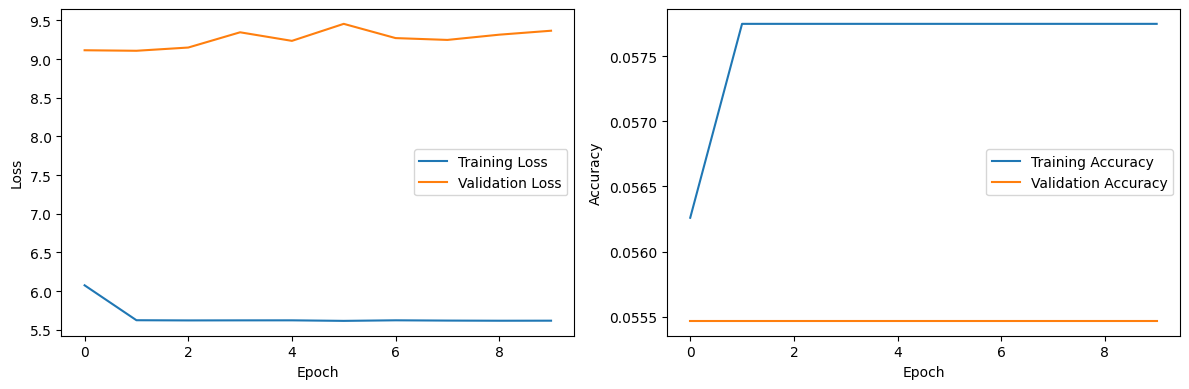

In [8]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [10]:
def generate_resume_text(
    seed_text,
    model,
    tokenizer,
    max_seq_length=100,
    num_tokens=50,
    temperature=1.0
):
    """
    Generate text continuation from a seed text using the trained model.
    
    Args:
        seed_text: Starting text for generation
        model: Trained language model
        tokenizer: Tokenizer used for training
        max_seq_length: Maximum sequence length for model input
        num_tokens: Number of tokens to generate
        temperature: Controls randomness (lower = more deterministic)
        
    Returns:
        Generated text continuation
    """
    generated_text = seed_text
    
    for _ in range(num_tokens):
        # Tokenize the current text
        token_sequence = tokenizer.texts_to_sequences([generated_text])[0]
        
        # Pad or truncate to match model input size
        if len(token_sequence) > max_seq_length:
            # Take only the last max_seq_length tokens
            token_sequence = token_sequence[-max_seq_length:]
        
        # Pad sequence if needed
        padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
            [token_sequence], 
            maxlen=max_seq_length
        )
        
        # Get model predictions
        predictions = model.predict(padded_sequence, verbose=0)[0, -1]
        
        # Apply temperature scaling for controlling randomness
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-9) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))
        
        # Sample next token based on probabilities
        next_token_id = np.random.choice(len(predictions), p=predictions)
        next_word = tokenizer.index_word.get(next_token_id, '')
        
        # Add the next word to the generated text
        if next_word:
            generated_text += ' ' + next_word
        else:
            # Break if we get an empty token
            break
    
    return generated_text

# # Load the saved model and tokenizer
# from tensorflow.keras.models import load_model

# Uncomment to load a saved model
# resume_model = load_model(
#     "resume_language_model.h5",
#     custom_objects={"PositionalEncoding": PositionalEncoding}
# )

with open("resume_tokenizer.pkl", 'rb') as f:
    resume_tokenizer = pickle.load(f)

# Generate text with different temperature settings
seed_phrases = [
    "My name is",
    "My skills include",
    "I worked at"
]

print("\n==== Generated Resume Text Samples ====\n")
for seed in seed_phrases:
    print(f"Seed: '{seed}'")
    
    # Generate with different temperature values
    for temp in [0.7, 1.0, 1.3]:
        generated = generate_resume_text(
            seed,
            resume_model,
            resume_tokenizer,
            temperature=temp
        )
        print(f"  Temperature {temp}: {generated}")
    print()


==== Generated Resume Text Samples ====

Seed: 'My name is'
  Temperature 0.7: My name is and applied the large and using and to for of text tools and tasks and and to and and capable intelligent and applications workflows of used and processing applications learning the sophisticated properly years real retrieval document and in learning in postman and html using for gcp using optimized and
  Temperature 1.0: My name is using and rag system services workflows extract comprehensive using depth predictive intelligent processing in writer developed for efficiently foundation specialized c of integrated created technologies comprehensive and level improvements applications recognition retrieval unstructured responses concepts ai complex used combining and generation sophisticated nlp experience for applications and extract gcp implementations
  Temperature 1.3: My name is advanced querying of of engineer information designed performance unstructured both flow requiring applied crafting p